In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from pynumdiff.smooth_finite_difference import butterdiff


2025-06-13 15:48:00,292 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2025-06-13 15:48:00,298 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2025-06-13 15:48:00,301 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



In [2]:
#HELPER FUNCTIONS

def calculate_heading_difference(pre_heading, post_heading):
    diff = post_heading - pre_heading
    return np.arctan2(np.sin(diff), np.cos(diff))

def unwrap_nan(arr, discont=np.pi, axis=-1):
    """
    Unwrap phase data while treating NaNs as gaps.
    """
    arr = np.asarray(arr)

    def _unwrap_1d(x):
        y = x.copy()
        mask = ~np.isnan(x)
        if not np.any(mask):
            return y

        idx = np.where(mask)[0]
        segments = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)

        for seg in segments:
            start, end = seg[0], seg[-1]
            y[start:end + 1] = np.unwrap(x[start:end + 1], discont=discont)
        return y
    return np.apply_along_axis(_unwrap_1d, axis, arr)

def savgol_filter_with_nans(y, window_length, polyorder, **kwargs):
    """
    Apply savgol_filter to an array that contains NaNs.
    The filter is only applied to contiguous segments of non-NaN values.

    Parameters:
    -----------
    y : array_like
        The data to be filtered
    window_length : int
        The length of the filter window (must be odd)
    polyorder : int
        The order of the polynomial used to fit the samples
    **kwargs : dict
        Additional arguments to pass to savgol_filter

    Returns:
    --------
    y_filtered : ndarray
        The filtered data with NaNs preserved in their original locations
    """
    # Create a copy of the input array to avoid modifying the original
    y_filtered = np.copy(y)

    # Find indices of non-NaN values
    valid_indices = ~np.isnan(y)

    if not np.any(valid_indices):
        return y_filtered  # Return original if all values are NaN

    # Find contiguous segments of valid data
    diff_indices = np.diff(np.concatenate(([0], valid_indices.astype(int), [0])))
    start_indices = np.where(diff_indices == 1)[0]
    end_indices = np.where(diff_indices == -1)[0]
    segments = zip(start_indices, end_indices)

    # Apply savgol_filter to each segment separately
    for start, end in segments:
        # Only apply filter if the segment is long enough
        if end - start >= window_length:
            y_filtered[start:end] = savgol_filter(
                y[start:end], window_length, polyorder, **kwargs
            )
        # Leave shorter segments unfiltered

    return y_filtered
def calculate_kinematic_parameters(head_x, head_y, abdomen_x, abdomen_y, fps=500):
    dt = 1.0 / 500  # If your data is always at 500 Hz, you can hardcode this, or use dt = 1.0 / fps for flexibility

    head_x = np.array(head_x)
    head_y = np.array(head_y)
    abdomen_x = np.array(abdomen_x)
    abdomen_y = np.array(abdomen_y)
    #head_x = gaussian_filter1d(head_x, sigma=2)
    #head_y = gaussian_filter1d(head_y, sigma=2)
    # Smoothing
    # head_x = savgol_filter_with_nans(head_x, window_length=31, polyorder=3)
    # head_y = savgol_filter_with_nans(head_y, window_length=31, polyorder=3)
    # abdomen_x = savgol_filter_with_nans(abdomen_x, window_length=31, polyorder=3)
    # abdomen_y = savgol_filter_with_nans(abdomen_y, window_length=31, polyorder=3)

    # Orientation (body axis)
    orientation = np.arctan2(head_y - abdomen_y, head_x - abdomen_x)
    orientation_unwrapped = unwrap_nan(orientation)
    # orientation = np.gradient(orientation_unwrapped, 1 / 500)

    angular_velocity_body = np.gradient(orientation_unwrapped, dt)
    
    # calculate centroid based on head and abodomen coordinates
    centroid_x = (head_x + abdomen_x) / 2
    centroid_y = (head_y + abdomen_y) / 2
    
    centroid_velocity_x = savgol_filter_with_nans(
        np.gradient(centroid_x, 1 / 500), window_length=31, polyorder=3
    )
    # centroid_x, centroid_velocity_x = butterdiff(centroid_x, dt=1/500, params=[1, 0.1])
    
    centroid_velocity_y = savgol_filter_with_nans(
        np.gradient(centroid_y, 1 / 500), window_length=31, polyorder=3
    )
    # centroid_y, centroid_velocity_y = butterdiff(centroid_y, dt=1/500, params=[1, 0.1])
    
    centroid_velocity = np.sqrt(centroid_velocity_x**2 + centroid_velocity_y**2)
    

    centroid_velocity = savgol_filter_with_nans(centroid_velocity, window_length=31, polyorder=3)
    #centroid_acceleration = savgol_filter_with_nans(
    # np.gradient(centroid_velocity, 1 / 500), window_length=41, polyorder=3)
    
    theta = np.arctan2(centroid_velocity_y, centroid_velocity_x)
    theta_unwrap = unwrap_nan(theta)
    #angular_velocity = gaussian_filter1d(theta_unwrap, 1/500)
    angular_velocity = savgol_filter_with_nans(
         np.gradient(theta_unwrap, 1 / 500), window_length=31, polyorder=3
    )
    
    # theta_unwrap, angular_velocity = butterdiff(theta_unwrap, dt=1/500, params=[1, 0.1])
    

    head_tail_distance = np.sqrt((head_x - abdomen_x)**2 + (head_y - abdomen_y)**2)
    return {
        'angular_velocity_body': angular_velocity_body,
        'angular_velocity': angular_velocity,
        'linear_velocity': centroid_velocity,
        'orientation': orientation,
        'head_tail_distance': head_tail_distance,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y
    }
def extract_response_window_by_frames(kinematic_data, frames, start_frame=345, end_frame=445):
    """
    Extract a fixed-size window of kinematic data, padding with NaN where data is missing.
    
    Args:
        kinematic_data: dict of parameter_name -> numpy array of values
        frames: numpy array of frame numbers corresponding to the data
        start_frame: first frame of the desired window (inclusive)
        end_frame: last frame of the desired window (exclusive)
    
    Returns:
        dict of parameter_name -> numpy array of length (end_frame - start_frame)
    """
    # Create the target frame range
    target_frames = np.arange(start_frame, end_frame)
    window_size = len(target_frames)
    
    # Find indices where target frames exist in the input frames
    # Using searchsorted for efficient lookup
    frame_indices = np.searchsorted(frames, target_frames)
    
    # Check which target frames actually exist in the input data
    valid_mask = (frame_indices < len(frames)) & (frames[frame_indices] == target_frames)
    
    extracted_data = {}
    
    for param_name, param_values in kinematic_data.items():
        # Initialize output array with NaN
        output_array = np.full(window_size, np.nan, dtype=param_values.dtype)
        
        # Fill in values where data exists
        if np.any(valid_mask):
            valid_indices = frame_indices[valid_mask]
            output_array[valid_mask] = param_values[valid_indices]
        
        extracted_data[param_name] = output_array
    
    return extracted_data

def correct_head_abdomen_flips(df: pd.DataFrame, jump_threshold: float = 20.0, max_interpolate: int = 5, verbose: bool = False) -> pd.DataFrame:
    """
    Corrects head-abdomen position swaps in drosophila tracking data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing at least columns: head.x, head.y, abdomen.x, abdomen.y
    jump_threshold : float
        Threshold in pixels for detecting sudden position jumps (default: 10.0)
    max_interpolate : int
        Maximum number of consecutive NaN points to interpolate (default: 5)
    
    Returns:
    --------
    pd.DataFrame
        Corrected dataframe with additional 'flipped' column indicating where corrections were made
    """
    # Create a copy to avoid modifying the original
    df_corrected = df.copy()
    
    # Initialize the flipped column
    df_corrected['flipped'] = False
    
    def get_movement_direction(df_subset: pd.DataFrame, n_frames: int = 10) -> Tuple[float, float]:
        """Calculate average movement direction over n_frames"""
        if len(df_subset) < 2:
            return 0.0, 0.0
        
        # Calculate center of mass for head and abdomen over these frames
        center_x = (df_subset['head.x'] + df_subset['abdomen.x']) / 2
        center_y = (df_subset['head.y'] + df_subset['abdomen.y']) / 2
        
        # Remove NaN values for calculation
        valid_center = pd.DataFrame({'x': center_x, 'y': center_y}).dropna()
        
        if len(valid_center) < 2:
            return 0.0, 0.0
        
        # Calculate movement vector
        dx = valid_center['x'].iloc[-1] - valid_center['x'].iloc[0]
        dy = valid_center['y'].iloc[-1] - valid_center['y'].iloc[0]
        
        # Normalize
        magnitude = np.sqrt(dx**2 + dy**2)
        if magnitude > 0:
            return dx / magnitude, dy / magnitude
        return 0.0, 0.0
    
    def get_heading_direction(row: pd.Series) -> Tuple[float, float]:
        """Calculate heading direction (abdomen to head vector) for a row"""
        if pd.isna(row['head.x']) or pd.isna(row['abdomen.x']):
            return 0.0, 0.0
            
        dx = row['head.x'] - row['abdomen.x']
        dy = row['head.y'] - row['abdomen.y']
        
        magnitude = np.sqrt(dx**2 + dy**2)
        if magnitude > 0:
            return dx / magnitude, dy / magnitude
        return 0.0, 0.0
    
    # Step 1: Check initial orientation
    valid_data = df_corrected.dropna(subset=['head.x', 'head.y', 'abdomen.x', 'abdomen.y'])
    
    if len(valid_data) < 10:
        print("Warning: Not enough valid data points for analysis")
        return df_corrected
    
    # Use first 10 valid frames for orientation check
    initial_frames = valid_data.head(10)
    movement_dir = get_movement_direction(initial_frames)
    
    # Get heading direction from first valid frame
    first_valid_row = valid_data.iloc[0]
    heading_dir = get_heading_direction(first_valid_row)
    
    # Calculate dot product to check alignment
    dot_product = movement_dir[0] * heading_dir[0] + movement_dir[1] * heading_dir[1]
    
    # If heading and movement are opposing, swap initially
    if dot_product < -0.1:
        print("Initial orientation appears incorrect - swapping head and abdomen")
        
        # Swap head and abdomen columns
        df_corrected[['head.x', 'abdomen.x']] = df_corrected[['abdomen.x', 'head.x']].values
        df_corrected[['head.y', 'abdomen.y']] = df_corrected[['abdomen.y', 'head.y']].values
        df_corrected['flipped'] = True
    
    # Step 2: Go frame by frame to detect jumps and switches
    prev_head_pos = None
    prev_abdomen_pos = None

    head_dist_list = []
    abd_dist_list = []
    
    for idx in range(len(df_corrected)):
        row = df_corrected.iloc[idx]
        
        # Skip if current frame has NaN values
        if pd.isna(row['head.x']) or pd.isna(row['head.y']) or pd.isna(row['abdomen.x']) or pd.isna(row['abdomen.y']):
            prev_head_pos = None
            prev_abdomen_pos = None
            continue
        
        current_head_pos = np.array([row['head.x'], row['head.y']])
        current_abdomen_pos = np.array([row['abdomen.x'], row['abdomen.y']])
        
        if prev_head_pos is not None:
            # Calculate distances moved
            head_dist = np.linalg.norm(current_head_pos - prev_head_pos)
            abdomen_dist = np.linalg.norm(current_abdomen_pos - prev_abdomen_pos)

            head_dist_list.append(head_dist)
            abd_dist_list.append(abdomen_dist)
            
            head_jumped = head_dist > jump_threshold
            abdomen_jumped = abdomen_dist > jump_threshold
            
            if head_jumped and abdomen_jumped:
                # Both points jumped - this indicates a switch
                if verbose:
                    print(f"Switch detected at frame {idx} (head: {head_dist:.1f}, abdomen: {abdomen_dist:.1f})")
                
                # Swap the coordinates for ONLY this frame
                df_corrected.loc[idx, ['head.x', 'abdomen.x']] = \
                    df_corrected.loc[idx, ['abdomen.x', 'head.x']].values
                df_corrected.loc[idx, ['head.y', 'abdomen.y']] = \
                    df_corrected.loc[idx, ['abdomen.y', 'head.y']].values
                
                # Toggle flipped status for this frame
                df_corrected.loc[idx, 'flipped'] = ~df_corrected.loc[idx, 'flipped']
                
                # Update current positions after swap
                current_head_pos = np.array([df_corrected.iloc[idx]['head.x'], df_corrected.iloc[idx]['head.y']])
                current_abdomen_pos = np.array([df_corrected.iloc[idx]['abdomen.x'], df_corrected.iloc[idx]['abdomen.y']])
                
            elif head_jumped:
                # Only head jumped - tracking error, set to NaN
                if verbose:
                    print(f"Head tracking error at frame {idx} (distance: {head_dist:.1f})")
                df_corrected.loc[idx, ['head.x', 'head.y']] = np.nan
                current_head_pos = None  # Don't use this for next comparison
                
            elif abdomen_jumped:
                # Only abdomen jumped - tracking error, set to NaN
                if verbose:
                    print(f"Abdomen tracking error at frame {idx} (distance: {abdomen_dist:.1f})")
                df_corrected.loc[idx, ['abdomen.x', 'abdomen.y']] = np.nan
                current_abdomen_pos = None  # Don't use this for next comparison
        
        # Update previous positions (only if current positions are valid)
        if current_head_pos is not None and not np.any(np.isnan(current_head_pos)):
            prev_head_pos = current_head_pos
        if current_abdomen_pos is not None and not np.any(np.isnan(current_abdomen_pos)):
            prev_abdomen_pos = current_abdomen_pos
    
    # Step 3: Interpolate NaN values
    print("Interpolating missing values...")
    
    for col in ['head.x', 'head.y', 'abdomen.x', 'abdomen.y']:
        df_corrected[col] = df_corrected[col].interpolate(
            method='linear', 
            limit=max_interpolate,
            limit_direction='both'
        )
    
    # Count total corrections
    total_flipped_frames = df_corrected['flipped'].sum()
    print(f"Correction complete. Frames with flipped data: {total_flipped_frames}")
    
    return df_corrected
   

In [3]:
def process_data(stim_csvs_folder, response_start_frame=350, response_end_frame=450):
    all_data = []
    stim_csvs = sorted(glob.glob(os.path.join(stim_csvs_folder, "*.csv")))
    pattern = r"obj_id_(\d+)_frame_(\d+)"
    
    for stim_csv in stim_csvs:
        print(f"==== Processing {stim_csv} ====")
        stim_df = pd.read_csv(stim_csv)
        slp2csv_folder = os.path.join(stim_csvs_folder,
            os.path.basename(os.path.normpath(stim_csv)).replace(".csv", "")
        )
        slp2csv_files = sorted(glob.glob(os.path.join(slp2csv_folder, "*.csv")))
        
        for idx, row in stim_df.iterrows():
            stim_obj_id = int(row["obj_id"])
            stim_frame = int(row["frame"])
            stim_heading = float(row["stim_heading"])
            matching_file = None
            
            for file in slp2csv_files:
                match = re.search(pattern, file)
                if match:
                    file_obj_id = int(match.group(1))
                    file_frame = int(match.group(2))
                    if file_obj_id == stim_obj_id and file_frame == stim_frame:
                        matching_file = file
                        break
            
            if matching_file is None:
                continue
                
            data_df = pd.read_csv(matching_file)
            data_df_interp = data_df.interpolate(method="linear", limit_direction="both", limit=10)
            #data_df = correct_head_abdomen_flips(data_df)
            frames = data_df_interp["frame_idx"].to_numpy()
            head_x = data_df_interp["head.x"].to_numpy()
            head_y = data_df_interp["head.y"].to_numpy()
            abdomen_x = data_df_interp["abdomen.x"].to_numpy()
            abdomen_y = data_df_interp["abdomen.y"].to_numpy()
            
            if not (np.any(frames >= response_start_frame) and np.any(frames < response_end_frame)):
                print(f"Not enough frames in required range ({response_start_frame}-{response_end_frame}) in file {matching_file}")
                continue
                
            try:
                kinematic_data = calculate_kinematic_parameters(head_x, head_y, abdomen_x, abdomen_y)
                response_window_data = extract_response_window_by_frames(
                    kinematic_data, frames, response_start_frame, response_end_frame
                )
                
                # Calculate pre-stimulus heading
                pre_mask = (frames >= 300) & (frames < 350)
                if np.any(pre_mask):
                    pre_orientation = kinematic_data['orientation'][pre_mask]
                    pre_heading_mean = circmean(pre_orientation, high=np.pi, low=-np.pi)
                else:
                    pre_heading_mean = kinematic_data['orientation'][0] if len(kinematic_data['orientation']) > 0 else np.nan
                
                # Calculate post-stimulus heading
                post_mask = (frames >= 400) & (frames < 450)
                if np.any(post_mask):
                    post_orientation = kinematic_data['orientation'][post_mask]
                    post_heading_mean = circmean(post_orientation, high=np.pi, low=-np.pi)
                else:
                    post_heading_mean = kinematic_data['orientation'][-1] if len(kinematic_data['orientation']) > 0 else np.nan
                
                # FIXED: Move all calculations outside the if/else blocks
                prepost_heading_difference = calculate_heading_difference(pre_heading_mean, post_heading_mean)
                prestim_heading_difference = calculate_heading_difference(pre_heading_mean, stim_heading)
                
                row_data = row.to_dict()
                row_data['prepost_heading_difference'] = prepost_heading_difference
                row_data['prestim_heading_difference'] = prestim_heading_difference
                
                # FIXED: Use consistent column names (remove '_mean' suffix)
                row_data['pre_heading'] = pre_heading_mean
                row_data['post_heading'] = post_heading_mean
                
                row_data['angular_velocity_timeseries'] = response_window_data['angular_velocity']
                row_data['linear_velocity_timeseries'] = response_window_data['linear_velocity']
                row_data['orientation_timeseries'] = response_window_data['orientation']
                row_data['head_tail_distance_timeseries'] = response_window_data['head_tail_distance']
                row_data['centroid_x_timeseries'] = response_window_data['centroid_x']
                row_data['centroid_y_timeseries'] = response_window_data['centroid_y']
                row_data['source_file'] = matching_file
                
                all_data.append(row_data)
                
            except Exception as e:
                print(f"Error processing kinematic data for {matching_file}: {str(e)}")
                continue
    
    result_df = pd.DataFrame(all_data)
    print(f"Combined DataFrame has {len(result_df)} rows")
    return result_df

# Re-run with the fixed function:
stim_csvs_folder = "/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/"
cantons_df = process_data(stim_csvs_folder, response_start_frame=350, response_end_frame=450)



==== Processing /gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20241121_151406.csv ====
==== Processing /gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20241126_171308.csv ====
Error processing kinematic data for /gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20241126_171308/obj_id_3584_frame_1449463.predictions.csv: index 96 is out of bounds for axis 0 with size 96
Not enough frames in required range (350-450) in file /gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20241126_171308/obj_id_3598_frame_1625169.predictions.csv
Error processing kinematic data for /gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20241126_171308/obj_id_3606_frame_1630270.predictions.csv: index 218 is out of bounds for axis 0 with size 218
Error processing kinematic data for /gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20241126_171308/obj_id_3610_frame_1646390.predictions.csv: index 174 is out of bounds for axis 0 with size 174
Error processing kinematic data for /

In [4]:
cantons_df 

,obj_id,frame,stim_heading,prepost_heading_difference,prestim_heading_difference,pre_heading,post_heading,angular_velocity_timeseries,linear_velocity_timeseries,orientation_timeseries,head_tail_distance_timeseries,centroid_x_timeseries,centroid_y_timeseries,source_file
0,3615.0,1649124.0,1.926853,-0.790249,2.540129,-0.613277,-1.403526,"[-26.300889578259874, -24.32406110290429, -21....","[3206.3269185763697, 3304.082861722779, 3406.1...","[-1.4426900147613941, -1.503027721039321, -1.4...","[60.67388270299063, 63.197677091406185, 60.954...","[1088.88671875, 1090.4583740234375, 1088.44598...","[758.8946838378906, 753.0670776367188, 746.683...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
1,633.0,898182.0,-0.757202,-0.137246,2.213984,-2.971186,-3.108433,"[-4.7695906303626865, -5.0794742403825435, -5....","[3071.290248346362, 3035.3399182321405, 2994.1...","[-3.0028445292097214, -2.9961749901844, -3.052...","[52.684895408357214, 53.1296673396891, 52.4201...","[1006.1505737304688, 998.9562683105469, 993.99...","[668.6796264648438, 668.5329284667969, 666.625...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
2,633.0,898807.0,-1.728550,1.140663,-2.040248,0.311698,1.452362,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
3,921.0,1335278.0,0.721428,-1.236853,0.546271,0.175157,-1.061696,"[-65.95468236167406, -68.6572814282998, -70.56...","[12052.032344962596, 13048.712075094867, 14132...","[0.1498016228555179, 0.07924190209445404, 0.14...","[56.54797033269959, 56.37110622819055, 57.0336...","[1868.5042114257812, 1884.0720825195312, 1896....","[1344.4171752929688, 1350.1071166992188, 1355....",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
4,2594.0,2672220.0,1.988573,-0.558741,1.229065,0.759509,0.200768,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,42407.0,768490.0,1.017972,1.745709,2.990859,-1.972887,-0.227177,"[-18.270122064576434, -21.25969371334739, -25....","[3690.705946293797, 3853.0842757089786, 4044.3...","[1.0670553321716878, 0.7553330891250856, 0.719...","[45.33192858489186, 3.0867870585868724, 2.8165...","[1210.7796020507812, 1205.22021484375, 1210.89...","[1963.954833984375, 1950.9739379882812, 1955.0...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
537,43441.0,823374.0,0.379706,1.416837,3.062747,-2.683041,-1.266204,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
538,46457.0,1016269.0,-2.331203,1.725562,1.307640,2.644343,-1.913280,"[-4.5016705007674025, -5.614622863110298, -6.6...","[4492.682445965007, 4469.433077080906, 4447.20...","[2.5173239458531143, 2.5447868169604515, 2.518...","[44.04472996956352, 42.92831153630038, 41.8303...","[996.1348571777344, 1005.7856140136719, 1010.9...","[798.8930358886719, 793.7759399414062, 787.941...",/gpfs/soma_fs/home/kotra/sleap_video_analysis/...
539,51785.0,1860206.0,-1.533825,0.441316,0.288286,-1.822111,-1.380795,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan,

In [5]:
def apply_directional_angular_velocity_logic(angular_velocity, stimulus_bin, sign_convention='cw_positive'):
    if stimulus_bin in ['front', 'back']:
        return np.abs(angular_velocity)
    elif stimulus_bin in ['front left', 'back left']:
        if sign_convention == 'ccw_positive':
            return -angular_velocity
        else:
            return angular_velocity
    elif stimulus_bin in ['front right', 'back right']:
        if sign_convention == 'ccw_positive':
            return angular_velocity
        else:
            return -angular_velocity
    else:
        return angular_velocity

def reorganize_data_by_stimulus_direction(df, sign_convention='cw_positive'):
    def get_stimulus_bin(prestim_heading_difference):
        angle_deg = np.degrees(prestim_heading_difference)
        angle_deg = ((angle_deg + 180) % 360) - 180
        if -30 <= angle_deg <= 30:
            return 'front'
        elif 30 < angle_deg <= 90:
            return 'front right'
        elif 90 < angle_deg <= 120:
            return 'back right'
        elif 120 < angle_deg <= 180 or -180 <= angle_deg <= -120:
            return 'back'
        elif -120 < angle_deg <= -90:
            return 'back left'
        elif -90 < angle_deg <= -30:
            return 'front left'
        else:
            return 'unknown'
    
    df['stimulus_bin'] = df['prestim_heading_difference'].apply(get_stimulus_bin)
    df = df[df['stimulus_bin'] != 'unknown']
    result_dict = {}
    all_bins = ['front', 'front left', 'front right', 'back', 'back left', 'back right']
    
    for bin_name in all_bins:
        bin_df = df[df['stimulus_bin'] == bin_name].copy()
        if len(bin_df) == 0:
            result_dict[bin_name] = {
                'file': [],
                'orientation': np.array([]).reshape(0, 100),
                'angular_velocity': np.array([]).reshape(0, 100),
                'linear_velocity': np.array([]).reshape(0, 100),
                'head_tail_distance': np.array([]).reshape(0, 100),
                # ADDED: Heading difference data
                'prepost_heading_difference': np.array([]),
                'prestim_heading_difference': np.array([]),
                'pre_heading': np.array([]),
                'post_heading': np.array([])
            }
            continue
        
        # Lists for time series data
        orientation_list = []
        angular_velocity_list = []
        linear_velocity_list = []
        head_tail_distance_list = []
        file_list = []
        
        # ADDED: Lists for heading data
        prepost_heading_diff_list = []
        prestim_heading_diff_list = []
        pre_heading_list = []
        post_heading_list = []
        
        for idx, row in bin_df.iterrows():
            try:
                # Extract time series data
                orientation = row['orientation_timeseries']
                angular_velocity = row['angular_velocity_timeseries']
                linear_velocity = row['linear_velocity_timeseries']
                head_tail_distance = row['head_tail_distance_timeseries']
                source_file = row['source_file']
                
                # ADDED: Extract heading data
                prepost_heading_diff = row['prepost_heading_difference']
                prestim_heading_diff = row['prestim_heading_difference']
                pre_heading = row['pre_heading']
                post_heading = row['post_heading']
                
                angular_velocity_processed = apply_directional_angular_velocity_logic(
                    angular_velocity, bin_name, sign_convention
                )
                
                if (
                    len(orientation) == 100 and 
                    len(angular_velocity_processed) == 100 and 
                    len(linear_velocity) == 100 and
                    len(head_tail_distance) == 100
                ):
                    # Store time series data
                    orientation_list.append(orientation)
                    angular_velocity_list.append(angular_velocity_processed)
                    linear_velocity_list.append(linear_velocity)
                    head_tail_distance_list.append(head_tail_distance)
                    file_list.append(source_file)
                    
                    # ADDED: Store heading data
                    prepost_heading_diff_list.append(prepost_heading_diff)
                    prestim_heading_diff_list.append(prestim_heading_diff)
                    pre_heading_list.append(pre_heading)
                    post_heading_list.append(post_heading)
                    
            except Exception as e:
                print(f"Error processing trial in bin {bin_name}: {e}")
                continue
        
        if len(orientation_list) > 0:
            result_dict[bin_name] = {
                'file': file_list,
                'orientation': np.array(orientation_list),
                'angular_velocity': np.array(angular_velocity_list),
                'linear_velocity': np.array(linear_velocity_list),
                'head_tail_distance': np.array(head_tail_distance_list),
                # ADDED: Heading difference arrays
                'prepost_heading_difference': np.degrees(np.array(prepost_heading_diff_list)),
                'prestim_heading_difference': np.degrees(np.array(prestim_heading_diff_list)),
                'pre_heading': np.degrees(np.array(pre_heading_list)),
                'post_heading': np.degrees(np.array(post_heading_list))
            }
        else:
            result_dict[bin_name] = {
                'file': [],
                'orientation': np.array([]).reshape(0, 100),
                'angular_velocity': np.array([]).reshape(0, 100),
                'linear_velocity': np.array([]).reshape(0, 100),
                'head_tail_distance': np.array([]).reshape(0, 100),
                # ADDED: Empty heading arrays
                'prepost_heading_difference': np.array([]),
                'prestim_heading_difference': np.array([]),
                'pre_heading': np.array([]),
                'post_heading': np.array([])
            }
    
    return result_dict
cantons_organized_data = reorganize_data_by_stimulus_direction(cantons_df, sign_convention='cw_positive')


In [6]:
cantons_organized_data

{'front': {'file': ['/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_389_frame_1249033.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_804_frame_1377916.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_804_frame_1378666.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_1268_frame_1428486.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_2042_frame_4508829.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3033_frame_7976693.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3060_frame_8144173.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3118_frame_8356531.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap

In [7]:
def find_consecutive_nans(arr):
    """
    Find the length of the longest consecutive NaN sequence in a 1D array.
    
    Parameters:
    -----------
    arr : np.array
        1D array to check for consecutive NaNs
    
    Returns:
    --------
    int : Length of longest consecutive NaN sequence
    """
    if len(arr) == 0:
        return 0
    
    is_nan = np.isnan(arr)
    
    if not np.any(is_nan):
        return 0  # No NaNs at all
    
    # Find consecutive groups of NaNs
    # diff will be 1 at start of NaN group, -1 at end
    diff = np.diff(np.concatenate(([False], is_nan, [False])).astype(int))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    if len(starts) == 0:
        return 0
    
    # Calculate lengths of each consecutive NaN group
    lengths = ends - starts
    return np.max(lengths) if len(lengths) > 0 else 0

def remove_nan_trials_advanced(organized_data, max_consecutive_nans=3):
    """
    Remove trials with NaN heading data OR too many consecutive NaNs in time series.
    
    Parameters:
    -----------
    organized_data : dict
        The organized data structure
    max_consecutive_nans : int
        Maximum allowed consecutive NaNs in angular_velocity or linear_velocity
    
    Returns:
    --------
    dict : Cleaned organized data
    dict : Detailed removal statistics
    """
    print(f"=== ADVANCED NaN CLEANING (max {max_consecutive_nans} consecutive NaNs) ===")
    
    cleaned_data = {}
    removal_stats = {}
    total_removed = 0
    total_original = 0
    
    for bin_name, bin_data in organized_data.items():
        if bin_data['angular_velocity'].shape[0] == 0:
            # No trials in this bin
            cleaned_data[bin_name] = bin_data.copy()
            removal_stats[bin_name] = {
                'original': 0,
                'removed_heading_nan': 0,
                'removed_consecutive_nan': 0,
                'final': 0
            }
            continue
        
        n_trials = bin_data['angular_velocity'].shape[0]
        total_original += n_trials
        
        # Track removal reasons
        heading_nan_mask = np.zeros(n_trials, dtype=bool)
        consecutive_nan_mask = np.zeros(n_trials, dtype=bool)
        
        # Check 1: Heading data for NaNs
        heading_fields = ['prepost_heading_difference', 'prestim_heading_difference', 'pre_heading', 'post_heading']
        for field in heading_fields:
            if field in bin_data:
                nan_mask = np.isnan(bin_data[field])
                heading_nan_mask |= nan_mask
        
        # Check 2: Consecutive NaNs in time series
        critical_time_series = ['angular_velocity', 'linear_velocity']
        
        for trial_idx in range(n_trials):
            max_consecutive_in_trial = 0
            
            for field in critical_time_series:
                if field in bin_data and bin_data[field].shape[0] > 0:
                    trial_data = bin_data[field][trial_idx, :]
                    consecutive_nans = find_consecutive_nans(trial_data)
                    max_consecutive_in_trial = max(max_consecutive_in_trial, consecutive_nans)
            
            if max_consecutive_in_trial > max_consecutive_nans:
                consecutive_nan_mask[trial_idx] = True
        
        # Combine removal masks
        remove_mask = heading_nan_mask | consecutive_nan_mask
        keep_mask = ~remove_mask
        
        # Count removals by reason
        n_removed_heading = np.sum(heading_nan_mask)
        n_removed_consecutive = np.sum(consecutive_nan_mask)
        n_removed_total = np.sum(remove_mask)
        n_keep = np.sum(keep_mask)
        
        total_removed += n_removed_total
        
        # Store statistics
        removal_stats[bin_name] = {
            'original': n_trials,
            'removed_heading_nan': n_removed_heading,
            'removed_consecutive_nan': n_removed_consecutive,
            'removed_both': np.sum(heading_nan_mask & consecutive_nan_mask),
            'removed_total': n_removed_total,
            'final': n_keep
        }
        
        # Apply the mask to create cleaned data
        if n_keep > 0:
            cleaned_bin_data = {}
            
            # Filter all arrays
            for field, values in bin_data.items():
                if field == 'file':
                    cleaned_bin_data[field] = [values[i] for i in range(len(values)) if keep_mask[i]]
                elif isinstance(values, np.ndarray) and len(values) == n_trials:
                    cleaned_bin_data[field] = values[keep_mask]
                else:
                    cleaned_bin_data[field] = values
            
            cleaned_data[bin_name] = cleaned_bin_data
        else:
            # Create empty structure
            cleaned_data[bin_name] = {
                'file': [],
                'orientation': np.array([]).reshape(0, 100),
                'angular_velocity': np.array([]).reshape(0, 100),
                'linear_velocity': np.array([]).reshape(0, 100),
                'head_tail_distance': np.array([]).reshape(0, 100),
                'prepost_heading_difference': np.array([]),
                'prestim_heading_difference': np.array([]),
                'pre_heading': np.array([]),
                'post_heading': np.array([])
            }
        
        print(f"  {bin_name}: {n_trials} → {n_keep} trials")
        print(f"    Removed for heading NaN: {n_removed_heading}")
        print(f"    Removed for consecutive NaN: {n_removed_consecutive}")
        if n_removed_heading > 0 and n_removed_consecutive > 0:
            overlap = np.sum(heading_nan_mask & consecutive_nan_mask)
            print(f"    Overlap (both issues): {overlap}")
    
    print(f"\nTOTAL: {total_original} → {total_original - total_removed} trials (removed {total_removed})")
    
    return cleaned_data, removal_stats

def analyze_consecutive_nans(organized_data, fields=['angular_velocity', 'linear_velocity']):
    """
    Analyze consecutive NaN patterns in the data to help choose threshold.
    """
    print("=== CONSECUTIVE NaN ANALYSIS ===")
    
    all_consecutive_lengths = []
    
    for bin_name, bin_data in organized_data.items():
        if bin_data['angular_velocity'].shape[0] == 0:
            continue
        
        bin_consecutive_lengths = []
        n_trials = bin_data['angular_velocity'].shape[0]
        
        for trial_idx in range(n_trials):
            trial_max_consecutive = 0
            
            for field in fields:
                if field in bin_data and bin_data[field].shape[0] > 0:
                    trial_data = bin_data[field][trial_idx, :]
                    consecutive_nans = find_consecutive_nans(trial_data)
                    trial_max_consecutive = max(trial_max_consecutive, consecutive_nans)
            
            bin_consecutive_lengths.append(trial_max_consecutive)
            all_consecutive_lengths.append(trial_max_consecutive)
        
        bin_consecutive_lengths = np.array(bin_consecutive_lengths)
        
        print(f"\n{bin_name} ({n_trials} trials):")
        print(f"  Max consecutive NaNs per trial:")
        print(f"    0 NaNs: {np.sum(bin_consecutive_lengths == 0)} trials")
        for i in range(1, 11):
            count = np.sum(bin_consecutive_lengths == i)
            if count > 0:
                print(f"    {i} consecutive: {count} trials")
        
        longer_than_10 = np.sum(bin_consecutive_lengths > 10)
        if longer_than_10 > 0:
            max_consecutive = np.max(bin_consecutive_lengths)
            print(f"    >10 consecutive: {longer_than_10} trials (max: {max_consecutive})")
    
    # Overall statistics
    all_consecutive_lengths = np.array(all_consecutive_lengths)
    print(f"\n=== OVERALL CONSECUTIVE NaN STATISTICS ===")
    print(f"Total trials analyzed: {len(all_consecutive_lengths)}")
    
    for threshold in [1, 2, 3, 4, 5, 10]:
        would_remove = np.sum(all_consecutive_lengths > threshold)
        percentage = 100 * would_remove / len(all_consecutive_lengths)
        print(f"Threshold >{threshold}: would remove {would_remove} trials ({percentage:.1f}%)")

def validate_cleaned_data(cleaned_data):
    """
    Validate that the cleaned data has no problematic NaN patterns.
    """
    print("=== CLEANED DATA VALIDATION ===")
    
    for bin_name, bin_data in cleaned_data.items():
        if bin_data['angular_velocity'].shape[0] == 0:
            continue
        
        n_trials = bin_data['angular_velocity'].shape[0]
        
        # Check heading data
        heading_fields = ['prepost_heading_difference', 'prestim_heading_difference', 'pre_heading', 'post_heading']
        heading_nans = 0
        for field in heading_fields:
            if field in bin_data:
                heading_nans += np.sum(np.isnan(bin_data[field]))
        
        # Check consecutive NaNs in time series
        max_consecutive_found = 0
        for trial_idx in range(n_trials):
            for field in ['angular_velocity', 'linear_velocity']:
                if field in bin_data:
                    trial_data = bin_data[field][trial_idx, :]
                    consecutive = find_consecutive_nans(trial_data)
                    max_consecutive_found = max(max_consecutive_found, consecutive)
        
        print(f"{bin_name}: {n_trials} trials")
        print(f"  Heading NaNs: {heading_nans} (should be 0)")
        print(f"  Max consecutive NaNs: {max_consecutive_found}")

# Usage workflow:

# Step 1: Analyze consecutive NaN patterns to choose threshold
print("Step 1: Analyzing consecutive NaN patterns...")
analyze_consecutive_nans(cantons_organized_data)

# Step 2: Clean with chosen threshold (you can adjust this)
print("\nStep 2: Cleaning data...")
cantons_cleaned, removal_stats = remove_nan_trials_advanced(
    cantons_organized_data, 
    max_consecutive_nans=3  # Adjust this based on the analysis above
)

# Step 3: Validate the results
print("\nStep 3: Validating cleaned data...")
validate_cleaned_data(cantons_cleaned)

# Step 4: Summary of what was removed
print("\n=== DETAILED REMOVAL SUMMARY ===")
for bin_name, stats in removal_stats.items():
    if stats['original'] > 0:
        print(f"{bin_name}:")
        print(f"  Original: {stats['original']} trials")
        print(f"  Removed for heading NaN: {stats['removed_heading_nan']}")
        print(f"  Removed for consecutive NaN: {stats['removed_consecutive_nan']}")
        print(f"  Final: {stats['final']} trials")
        retention_rate = 100 * stats['final'] / stats['original']
        print(f"  Retention rate: {retention_rate:.1f}%")
        print()


Step 1: Analyzing consecutive NaN patterns...
=== CONSECUTIVE NaN ANALYSIS ===

front (215 trials):
  Max consecutive NaNs per trial:
    0 NaNs: 111 trials
    1 consecutive: 1 trials
    5 consecutive: 1 trials
    7 consecutive: 1 trials
    9 consecutive: 2 trials
    10 consecutive: 3 trials
    >10 consecutive: 96 trials (max: 100)

front left (56 trials):
  Max consecutive NaNs per trial:
    0 NaNs: 33 trials
    6 consecutive: 1 trials
    10 consecutive: 2 trials
    >10 consecutive: 20 trials (max: 100)

front right (64 trials):
  Max consecutive NaNs per trial:
    0 NaNs: 33 trials
    7 consecutive: 1 trials
    8 consecutive: 1 trials
    >10 consecutive: 29 trials (max: 100)

back (118 trials):
  Max consecutive NaNs per trial:
    0 NaNs: 70 trials
    2 consecutive: 1 trials
    4 consecutive: 1 trials
    7 consecutive: 1 trials
    9 consecutive: 2 trials
    10 consecutive: 1 trials
    >10 consecutive: 42 trials (max: 100)

back left (26 trials):
  Max consecutive

In [41]:
cantons_cleaned

{'front': {'file': ['/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_804_frame_1378666.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_1268_frame_1428486.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3060_frame_8144173.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3118_frame_8356531.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_144_frame_184162.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_148_frame_185133.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_185_frame_189577.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_238_frame_192679.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video

In [8]:

import os
import pandas as pd
import numpy as np

def fix_and_save_data(cleaned_data, output_folder, group_name):
    """
    Fix source file paths and save to CSV files in one step.
    
    Parameters:
    -----------
    cleaned_data : dict
        The cleaned organized data structure
    output_folder : str
        Path to save CSV files
    group_name : str
        Prefix for filenames
    
    Returns:
    --------
    dict : Corrected cleaned data
    """
    # Fix file paths
    old_pattern = "202504_23,24_160499"
    new_pattern = "20250325_160449"
    
    corrected_data = {}
    total_fixes = 0
    
    for bin_name, bin_data in cleaned_data.items():
        corrected_bin_data = bin_data.copy()
        
        if 'file' in bin_data and len(bin_data['file']) > 0:
            corrected_files = []
            for file_path in bin_data['file']:
                if old_pattern in file_path:
                    corrected_files.append(file_path.replace(old_pattern, new_pattern))
                    total_fixes += 1
                else:
                    corrected_files.append(file_path)
            corrected_bin_data['file'] = corrected_files
        
        corrected_data[bin_name] = corrected_bin_data
    
    print(f"Fixed {total_fixes} file paths")
    
    # Save to CSV files
    os.makedirs(output_folder, exist_ok=True)
    bins = ['front', 'front left', 'front right', 'back', 'back left', 'back right']
    
    for bin_name in bins:
        bin_data = corrected_data.get(bin_name, {})
        
        if 'angular_velocity' not in bin_data or bin_data['angular_velocity'].shape[0] == 0:
            continue
        
        n_trials = bin_data['angular_velocity'].shape[0]
        trials = []
        
        for trial_idx in range(n_trials):
            trial_row = {
                'trial_id': trial_idx,
                'source_file': bin_data['file'][trial_idx] if 'file' in bin_data else f"trial_{trial_idx}",
                'prestim_heading_difference_deg': (bin_data['prestim_heading_difference'][trial_idx]),
                'prepost_heading_difference_deg': (bin_data['prepost_heading_difference'][trial_idx]),
                'pre_heading_deg': (bin_data['pre_heading'][trial_idx]),
                'post_heading_deg': (bin_data['post_heading'][trial_idx]),
                'angular_velocity_deg_array': ','.join([f"{val:.3f}" if not np.isnan(val) else "NaN" 
                                                       for val in np.degrees(bin_data['angular_velocity'][trial_idx, :])]),
                'linear_velocity_array': ','.join([f"{val:.3f}" if not np.isnan(val) else "NaN" 
                                                  for val in bin_data['linear_velocity'][trial_idx, :]])
            }
            trials.append(trial_row)
        
        # Save to CSV
        df = pd.DataFrame(trials)
        safe_bin_name = bin_name.replace(' ', '_')
        filename = f"{group_name}_{safe_bin_name}.csv"
        filepath = os.path.join(output_folder, filename)
        df.to_csv(filepath, index=False)
        print(f"Saved {bin_name}: {n_trials} trials → {filename}")
    
    return corrected_data

# Usage:
cantons_final = fix_and_save_data(
    cleaned_data=cantons_cleaned,
    output_folder="./final_csv_output/canton-s/",
    group_name="canton_s_final"
)


Fixed 0 file paths
Saved front: 112 trials → canton_s_final_front.csv
Saved front left: 33 trials → canton_s_final_front_left.csv
Saved front right: 33 trials → canton_s_final_front_right.csv
Saved back: 71 trials → canton_s_final_back.csv
Saved back left: 12 trials → canton_s_final_back_left.csv
Saved back right: 19 trials → canton_s_final_back_right.csv


In [59]:
cantons_final

{'front': {'file': ['/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_804_frame_1378666.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_1268_frame_1428486.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3060_frame_8144173.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3118_frame_8356531.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_144_frame_184162.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_148_frame_185133.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_185_frame_189577.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_238_frame_192679.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video

In [9]:
def analyze_and_split_by_responsiveness_with_degrees(cleaned_data, threshold_deg_per_sec=1000):
    """
    Modified version that converts angular velocity to degrees and preserves it.
    """
    
    # Step 1: Add peak detection analysis
    print(f"=== PEAK DETECTION ANALYSIS (threshold: {threshold_deg_per_sec}°/s) ===")
    
    threshold_rad_per_sec = np.radians(threshold_deg_per_sec)
    data_with_peaks = {}
    
    for bin_name, bin_data in cleaned_data.items():
        data_with_peaks[bin_name] = bin_data.copy()
        
        if bin_data['angular_velocity'].size == 0:
            data_with_peaks[bin_name]['responsive'] = np.array([])
            # Add empty degrees array
            data_with_peaks[bin_name]['angular_velocity_deg'] = np.array([]).reshape(0, 100)
            continue
        
        # CONVERT TO DEGREES AND STORE
        angular_velocity_deg = np.degrees(bin_data['angular_velocity'])
        data_with_peaks[bin_name]['angular_velocity_deg'] = angular_velocity_deg
        
        responsive_list = []
        for trial_idx in range(bin_data['angular_velocity'].shape[0]):
            angular_vel_trial = bin_data['angular_velocity'][trial_idx, :]  # Still use radians for peak detection
            peaks, properties = find_peaks(np.abs(angular_vel_trial), height=threshold_rad_per_sec)
            is_responsive = len(peaks) > 0
            responsive_list.append(is_responsive)
        
        data_with_peaks[bin_name]['responsive'] = np.array(responsive_list, dtype=bool)
        
        n_responsive = np.sum(responsive_list)
        n_total = len(responsive_list)
        print(f"  {bin_name}: {n_responsive}/{n_total} responsive ({100*n_responsive/n_total:.1f}%)")
    
    # Step 2: Split into responsive and non-responsive datasets
    print(f"\n=== SPLITTING DATA BY RESPONSIVENESS ===")
    
    responsive_data = {}
    non_responsive_data = {}
    summary_stats = {}
    
    for bin_name, bin_data in data_with_peaks.items():
        if bin_data['angular_velocity'].size == 0:
            # Empty bin
            empty_structure = {
                'file': [],
                'orientation': np.array([]).reshape(0, 100),
                'angular_velocity': np.array([]).reshape(0, 100),
                'angular_velocity_deg': np.array([]).reshape(0, 100),  # ADD DEGREES VERSION
                'linear_velocity': np.array([]).reshape(0, 100),
                'head_tail_distance': np.array([]).reshape(0, 100),
                'prepost_heading_difference': np.array([]),
                'prestim_heading_difference': np.array([]),
                'pre_heading': np.array([]),
                'post_heading': np.array([]),
                'responsive': np.array([])
            }
            responsive_data[bin_name] = empty_structure.copy()
            non_responsive_data[bin_name] = empty_structure.copy()
            
            summary_stats[bin_name] = {
                'total': 0,
                'responsive': 0,
                'non_responsive': 0,
                'responsive_percentage': 0
            }
            continue
        
        # Create masks
        responsive_mask = bin_data['responsive']
        non_responsive_mask = ~responsive_mask
        
        # Split responsive trials
        responsive_data[bin_name] = {}
        for field, values in bin_data.items():
            if field == 'file':
                responsive_data[bin_name][field] = [values[i] for i in range(len(values)) if responsive_mask[i]]
            elif isinstance(values, np.ndarray) and len(values) == len(responsive_mask):
                responsive_data[bin_name][field] = values[responsive_mask]
            else:
                responsive_data[bin_name][field] = values
        
        # Split non-responsive trials
        non_responsive_data[bin_name] = {}
        for field, values in bin_data.items():
            if field == 'file':
                non_responsive_data[bin_name][field] = [values[i] for i in range(len(values)) if non_responsive_mask[i]]
            elif isinstance(values, np.ndarray) and len(values) == len(responsive_mask):
                non_responsive_data[bin_name][field] = values[non_responsive_mask]
            else:
                non_responsive_data[bin_name][field] = values
        
        # Summary statistics
        n_total = len(responsive_mask)
        n_responsive = np.sum(responsive_mask)
        n_non_responsive = np.sum(non_responsive_mask)
        
        summary_stats[bin_name] = {
            'total': n_total,
            'responsive': n_responsive,
            'non_responsive': n_non_responsive,
            'responsive_percentage': 100 * n_responsive / n_total if n_total > 0 else 0
        }
        
        print(f"  {bin_name}: {n_responsive} responsive, {n_non_responsive} non-responsive")
    
    return responsive_data, non_responsive_data, summary_stats


In [10]:
cantons_responsive = analyze_and_split_by_responsiveness_with_degrees(cantons_final, threshold_deg_per_sec=1000)


cs_responsive_data = cantons_responsive[0]
cs_non_responsive_data = cantons_responsive[1] 
cs_summary_stats = cantons_responsive[2]

cs_non_responsive_data #dict with nonresponsive trials
cs_responsive_data #dict with responsive trials 



=== PEAK DETECTION ANALYSIS (threshold: 1000°/s) ===
  front: 111/112 responsive (99.1%)
  front left: 32/33 responsive (97.0%)
  front right: 32/33 responsive (97.0%)
  back: 55/71 responsive (77.5%)
  back left: 9/12 responsive (75.0%)
  back right: 18/19 responsive (94.7%)

=== SPLITTING DATA BY RESPONSIVENESS ===
  front: 111 responsive, 1 non-responsive
  front left: 32 responsive, 1 non-responsive
  front right: 32 responsive, 1 non-responsive
  back: 55 responsive, 16 non-responsive
  back left: 9 responsive, 3 non-responsive
  back right: 18 responsive, 1 non-responsive


{'front': {'file': ['/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_804_frame_1378666.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_1268_frame_1428486.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3060_frame_8144173.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250102_152013/obj_id_3118_frame_8356531.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_144_frame_184162.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_148_frame_185133.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_185_frame_189577.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video_analysis/canton-s/20250411_175919/obj_id_238_frame_192679.predictions.csv',
   '/gpfs/soma_fs/home/kotra/sleap_video

/gpfs/soma_fs/home/kotra/micromamba/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


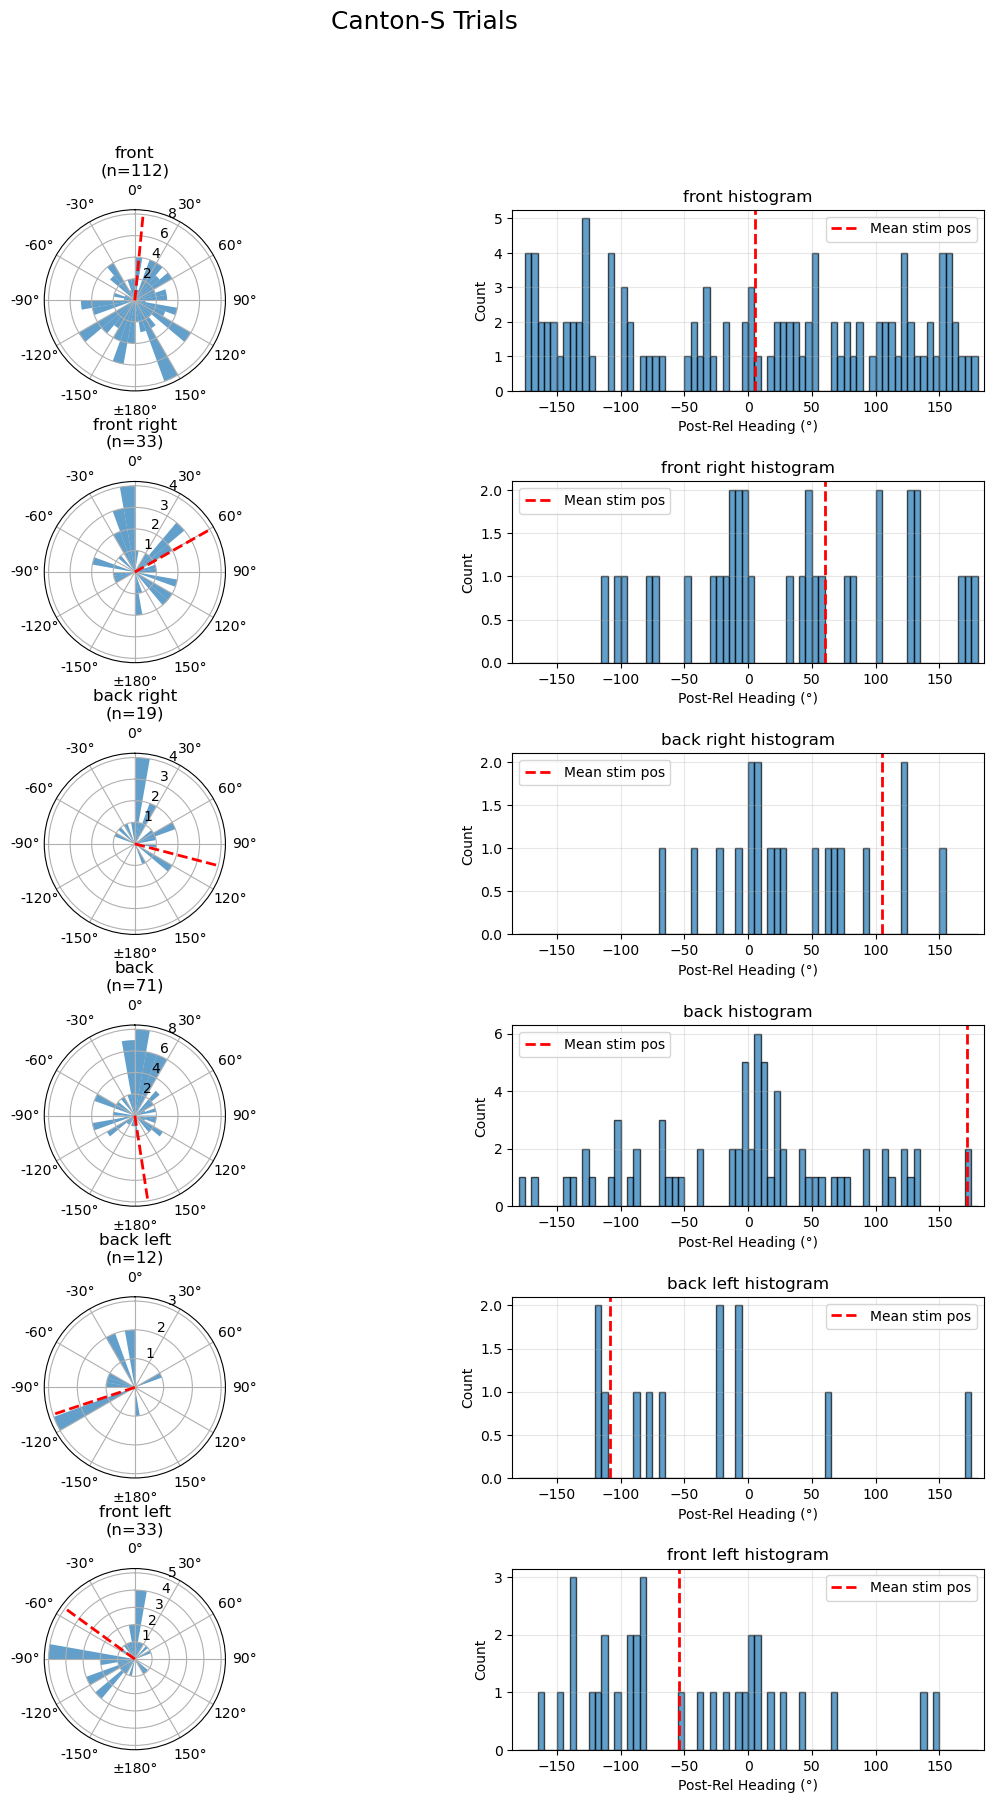

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import circmean



# Simple version if you're sure everything is in degrees
def plot_heading_histograms_simple_degrees(organized_data, title="Heading"):
    """
    Simple version assuming ALL heading data is already in degrees.
    """
    all_trials = []
    
    for bin_name, bin_data in organized_data.items():
        if bin_data['orientation'].size == 0:
            continue
        
        n_trials = bin_data['orientation'].shape[0]
        
        for trial_idx in range(n_trials):
            # Assume all heading values are in degrees
            pre_heading = bin_data['pre_heading'][trial_idx]  # Use _deg version
            post_heading = bin_data['post_heading'][trial_idx]  # Use _deg version
            prestim_diff = bin_data['prestim_heading_difference'][trial_idx]  # Use _deg version
            
            trial_data = {
                'pre_heading': pre_heading,
                'post_heading': post_heading,
                'prestim_heading_difference': prestim_diff,
                'bin_name': bin_name
            }
            all_trials.append(trial_data)
    
    df = pd.DataFrame(all_trials)
    a = df.copy()
    
    # Data already in degrees
    a['pre_deg'] = a['pre_heading']
    a['post_deg'] = a['post_heading']
    a['stim_deg'] = a['prestim_heading_difference']
    
    # Normalize to [-180, 180]
    for col in ['pre_deg', 'post_deg', 'stim_deg']:
        a[col] = ((a[col] + 180) % 360) - 180
    
    a['post_rel'] = ((a['pre_deg'] - a['post_deg'] + 180) % 360) - 180
    a['sector'] = a['bin_name']
    
    # Rest of the plotting code same as above...
    sectors = ['front', 'front right', 'back right', 'back', 'back left', 'front left']
    bins_rad = np.linspace(-np.pi, np.pi, 37)
    bins_deg = np.linspace(-180, 180, 73)
    width = bins_rad[1] - bins_rad[0]
    
    fig = plt.figure(figsize=(14, 20))
    gs = fig.add_gridspec(6, 2, hspace=0.5, wspace=0.3)
    
    for i, sec in enumerate(sectors):
        sub = a[a['sector'] == sec]
        axp = fig.add_subplot(gs[i, 0], projection='polar')
        
        if len(sub):
            post_rads = np.radians(sub['post_rel'])
            counts, edges = np.histogram(post_rads, bins=bins_rad)
            centers = (edges[:-1] + edges[1:]) / 2
            axp.bar(centers, counts, width=width, alpha=0.7, color='C0')
            
            stim_rads = np.radians(sub['stim_deg'].dropna())
            if len(stim_rads):
                z = np.exp(1j * stim_rads)
                mean_stim = np.angle(z.mean())
                axp.plot([mean_stim, mean_stim], [0, counts.max()],
                         color='red', linestyle='--', lw=2)
        
        axp.set_theta_zero_location("N")
        axp.set_theta_direction(-1)
        axp.set_xticks(np.pi/6 * np.arange(12))
        axp.set_xticklabels(['0°','30°','60°','90°','120°','150°','±180°','-150°','-120°','-90°','-60°','-30°'])
        axp.set_title(f"{sec}\n(n={len(sub)})")
        
        axh = fig.add_subplot(gs[i, 1])
        if len(sub):
            axh.hist(sub['post_rel'], bins=bins_deg, color='C0', edgecolor='k', alpha=0.7)
            # stim_deg_clean = sub['stim_deg'].dropna()
            # if len(stim_deg_clean):
            #     mean_stim_deg = circmean(np.radians(stim_deg_clean))
            #     mean_stim_deg = np.degrees(mean_stim_deg)
            axh.axvline(np.rad2deg(mean_stim), color='red', linestyle='--', lw=2, label='Mean stim pos')
            axh.legend()
    
        axh.set_xlim(-185, 185)
        axh.set_xlabel("Post-Rel Heading (°)")
        axh.set_ylabel("Count")
        axh.set_title(f"{sec} histogram")
        axh.grid(alpha=0.3)
    
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

# Usage:
# If you have the degrees fields (_deg versions):
plot_heading_histograms_simple_degrees(cantons_final, title="Canton-S Trials")

# If you want the smart version that auto-detects:
# plot_heading_histograms_degrees_fixed(cantons_final, title="Canton-S Trials")

In [16]:
def plot_combined_velocities(organized_data, group_name="Dataset"):
    """
    Simplified version assuming angular velocity data is already in degrees.
    """
    
    fig, axes = plt.subplots(2, 6, figsize=(26, 12))
    
    bin_names = ['front', 'front left', 'front right', 'back', 'back left', 'back right']
    colors = ['green', 'orange', 'blue', 'red', 'purple', 'brown']
    time_frames = np.arange(100)
    
    for i, bin_name in enumerate(bin_names):
        bin_data = organized_data.get(bin_name, {})
        
        # Angular velocity subplot (top row)
        ax_angular = axes[0, i]
        ax_linear = axes[1, i]
        
        if 'angular_velocity' in bin_data or bin_data['angular_velocity'].size != 0:
          
            ax_angular.set_title(f'{bin_name.capitalize()}\nAngular Velocity (n=0)')
            angular_vel = bin_data['angular_velocity_deg']
            mean_angular_vel = np.nanmean(angular_vel, axis=0)
            sem_angular_vel = np.nanstd(angular_vel, axis=0) / np.sqrt(angular_vel.shape[0])
            
            # Data already in degrees - use directly
            ax_angular.plot(time_frames, mean_angular_vel, color=colors[i], linewidth=2)
            ax_angular.fill_between(time_frames, 
                                  mean_angular_vel - sem_angular_vel,
                                  mean_angular_vel + sem_angular_vel,
                                  alpha=0.3, color=colors[i])
            
            ax_angular.axhline(0, color='black', linestyle='-', alpha=0.3)
            ax_angular.axvline(50, color='red', linestyle='--', alpha=0.5)
            threshold_deg = 1000
            ax_angular.axhline(threshold_deg, color='gray', linestyle=':', alpha=0.5)
            ax_angular.axhline(-threshold_deg, color='gray', linestyle=':', alpha=0.5)
            
            ax_angular.set_title(f'{bin_name.capitalize()}\nAngular Velocity (n={angular_vel.shape[0]})')
        
            ax_angular.set_ylabel('Angular Velocity (°/s)')
            ax_angular.grid(True, alpha=0.3)
            ax_angular.set_xlim(0, 99)
            
            # Linear velocity subplot (bottom row) - same as before
        
        
        if 'linear_velocity'in bin_data or bin_data['linear_velocity'].size != 0:
           
            ax_linear.set_title(f'Linear Velocity (n=0)')
            linear_vel = bin_data['linear_velocity']
            mean_linear_vel = np.nanmean(linear_vel, axis=0)
            sem_linear_vel = np.nanstd(linear_vel, axis=0) / np.sqrt(linear_vel.shape[0])
            
            ax_linear.plot(time_frames, mean_linear_vel, color=colors[i], linewidth=2)
            ax_linear.fill_between(time_frames, 
                                    mean_linear_vel - sem_linear_vel,
                                    mean_linear_vel + sem_linear_vel,
                                    alpha=0.3, color=colors[i])
            
            ax_linear.axhline(0, color='black', linestyle='-', alpha=0.3)
            ax_linear.axvline(50, color='red', linestyle='--', alpha=0.5)
            
            ax_linear.set_title(f'Linear Velocity (n={linear_vel.shape[0]})')
        
            ax_linear.set_xlabel('Frame (relative to stimulus window)')
            ax_linear.set_ylabel('Linear Velocity (pixels/s)')
            ax_linear.grid(True, alpha=0.3)
            ax_linear.set_xlim(0, 99)
        # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', linestyle='--', alpha=0.5, label='Stimulus center'),
        Line2D([0], [0], color='gray', linestyle=':', alpha=0.5, label='Response threshold'),
        Line2D([0], [0], color='black', linestyle='-', alpha=0.3, label='Zero line')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.suptitle(f'{group_name} - Angular & Linear Velocity by Stimulus Direction', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

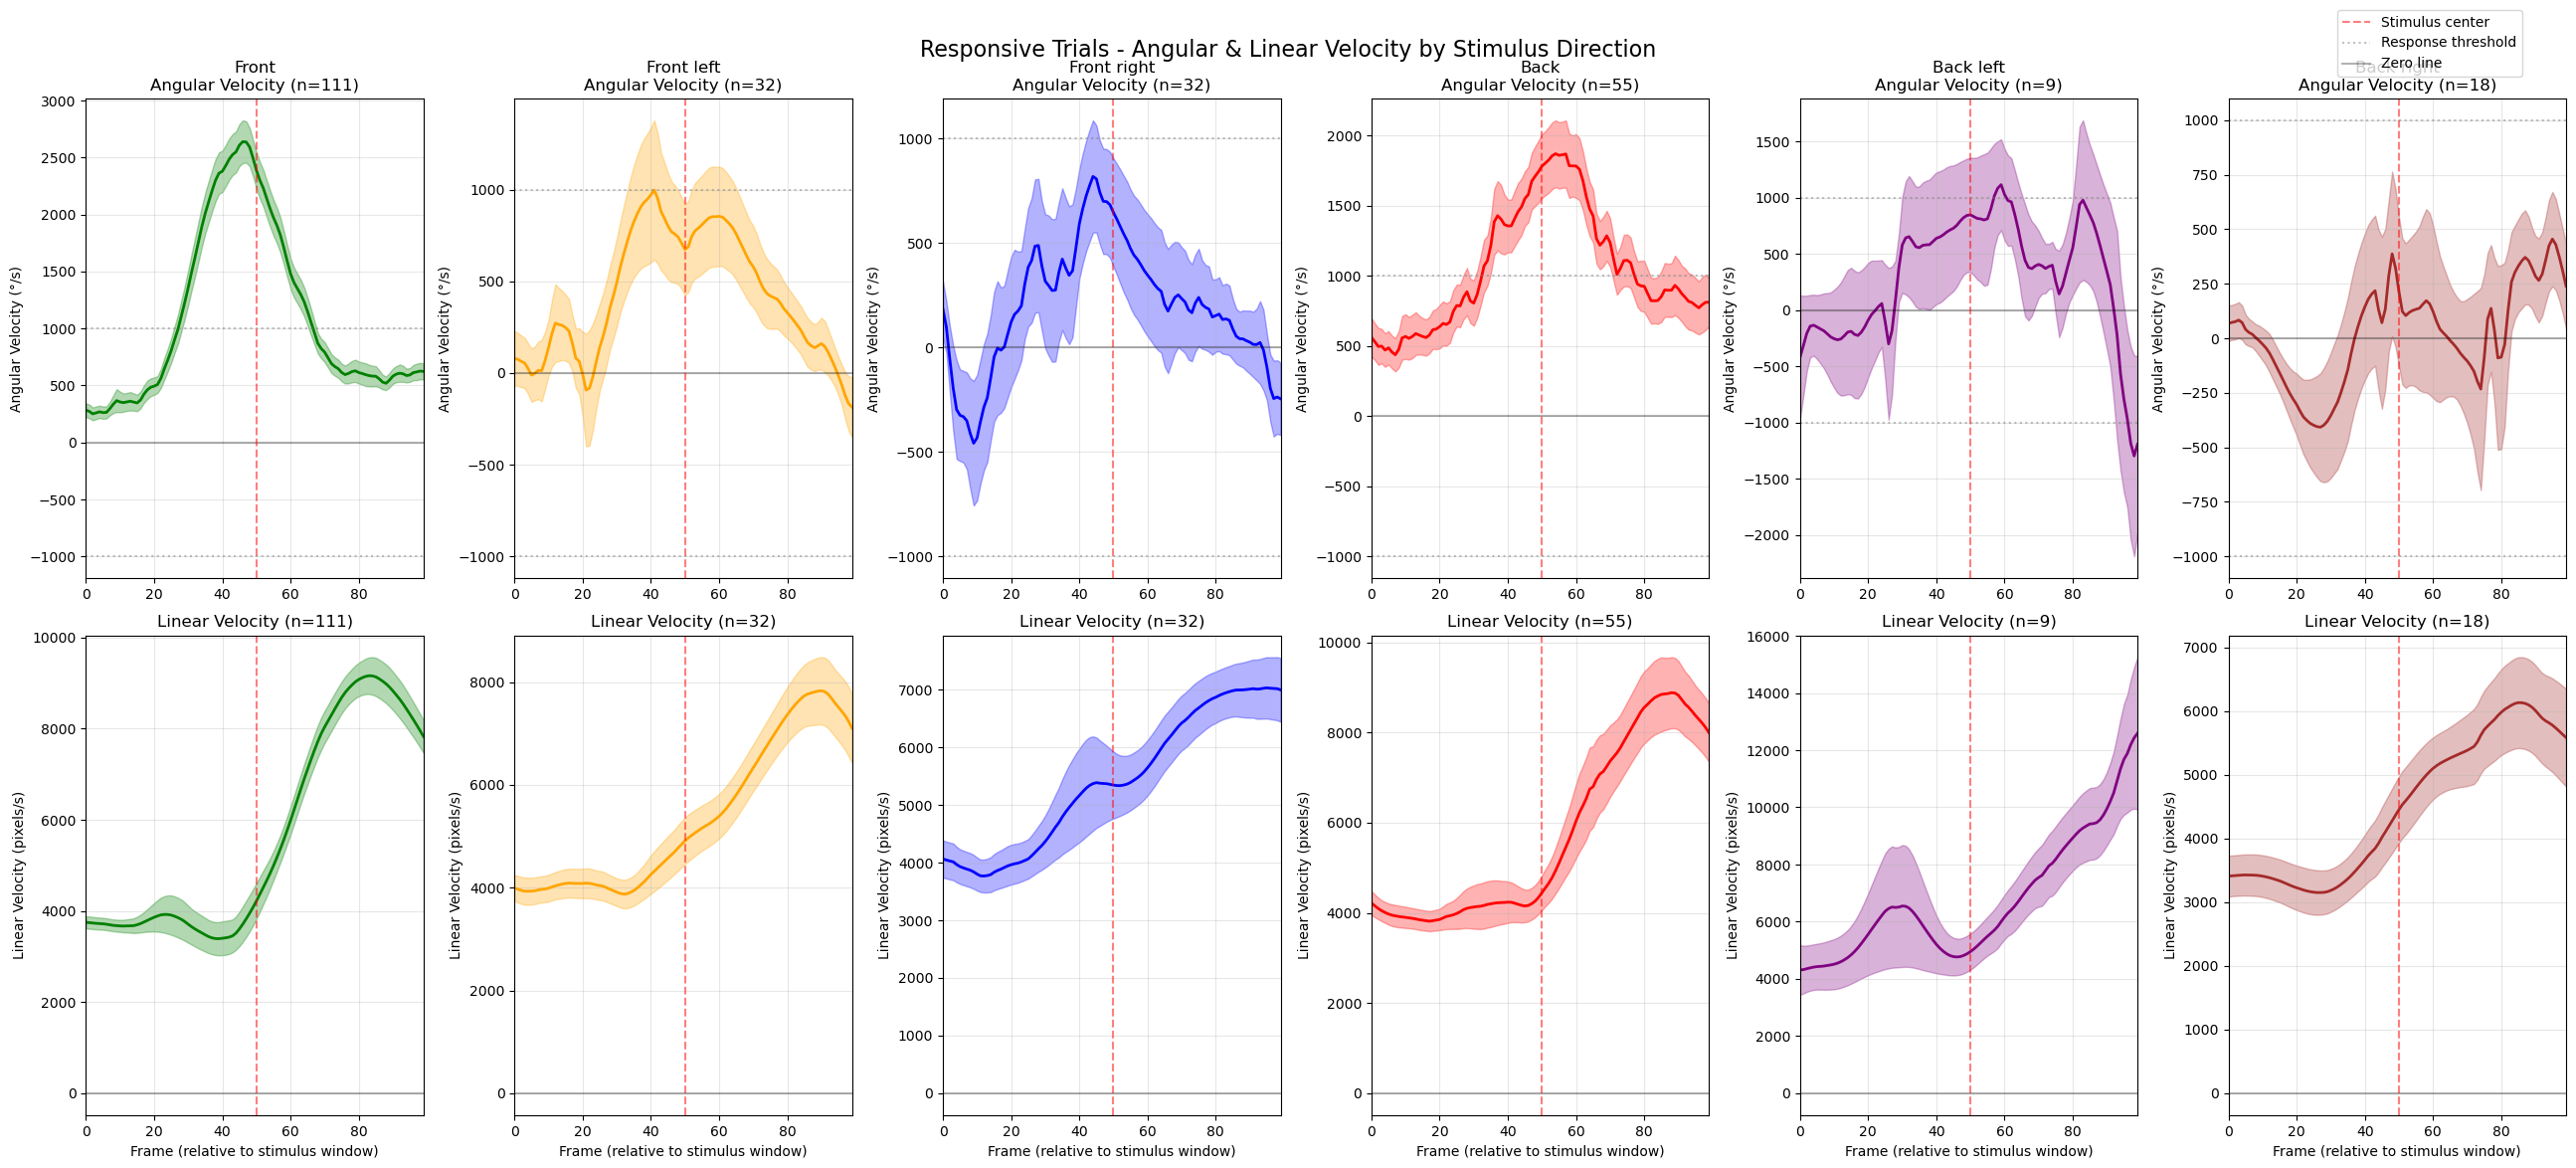

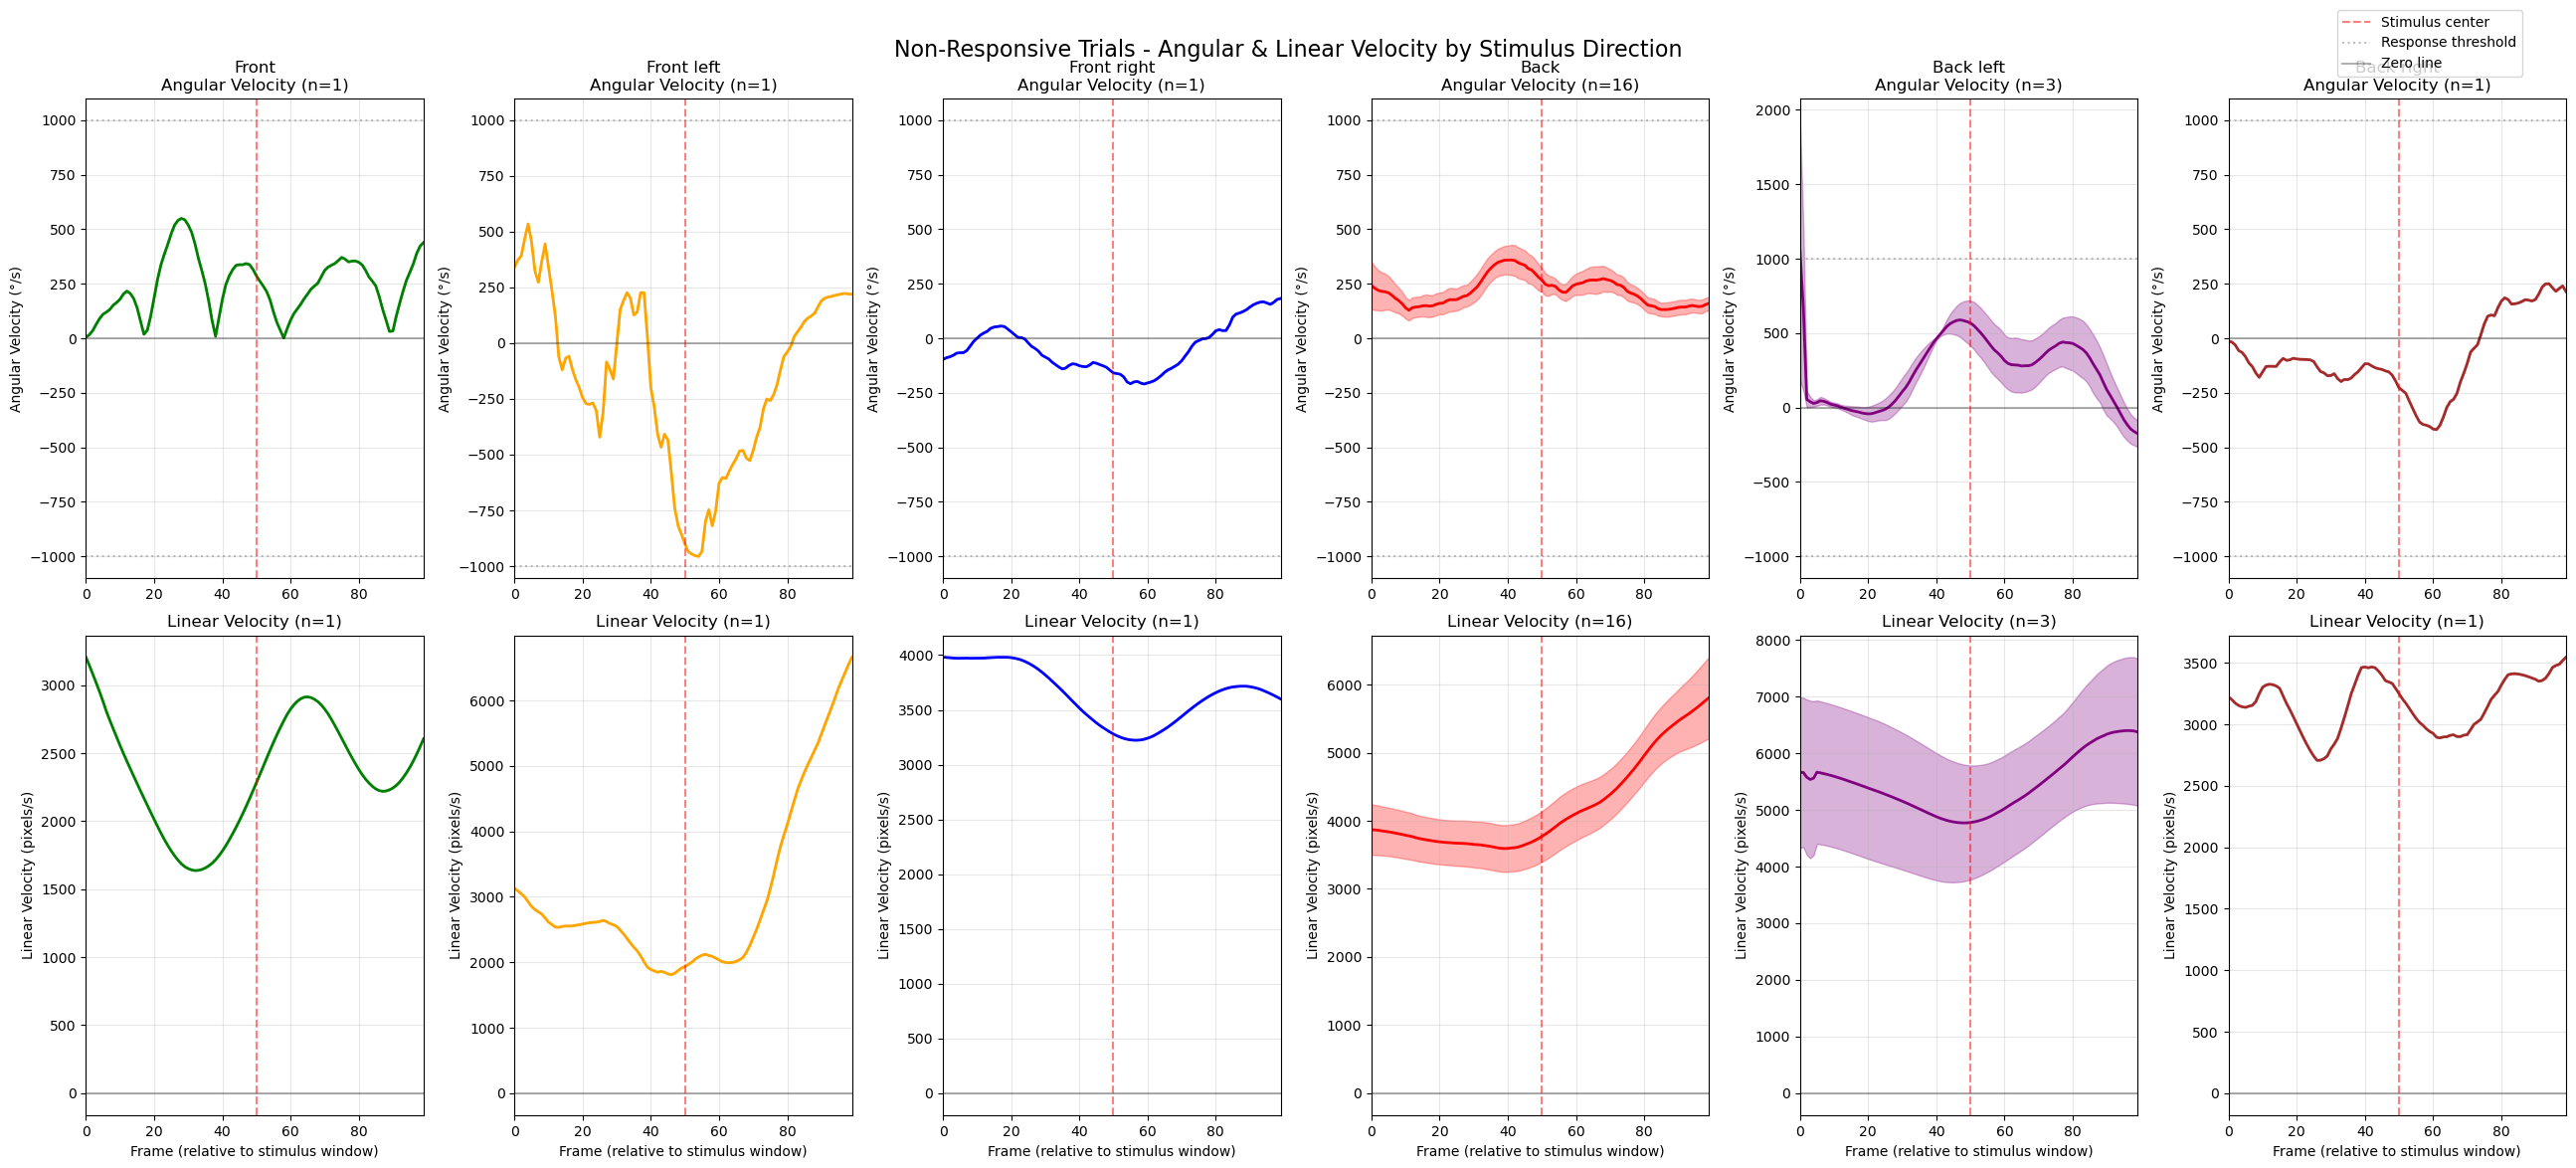

In [17]:
plot_combined_velocities(cs_responsive_data, group_name="Responsive Trials")
plot_combined_velocities(cs_non_responsive_data, group_name="Non-Responsive Trials")


/gpfs/soma_fs/home/kotra/micromamba/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/gpfs/soma_fs/home/kotra/micromamba/envs/analysis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


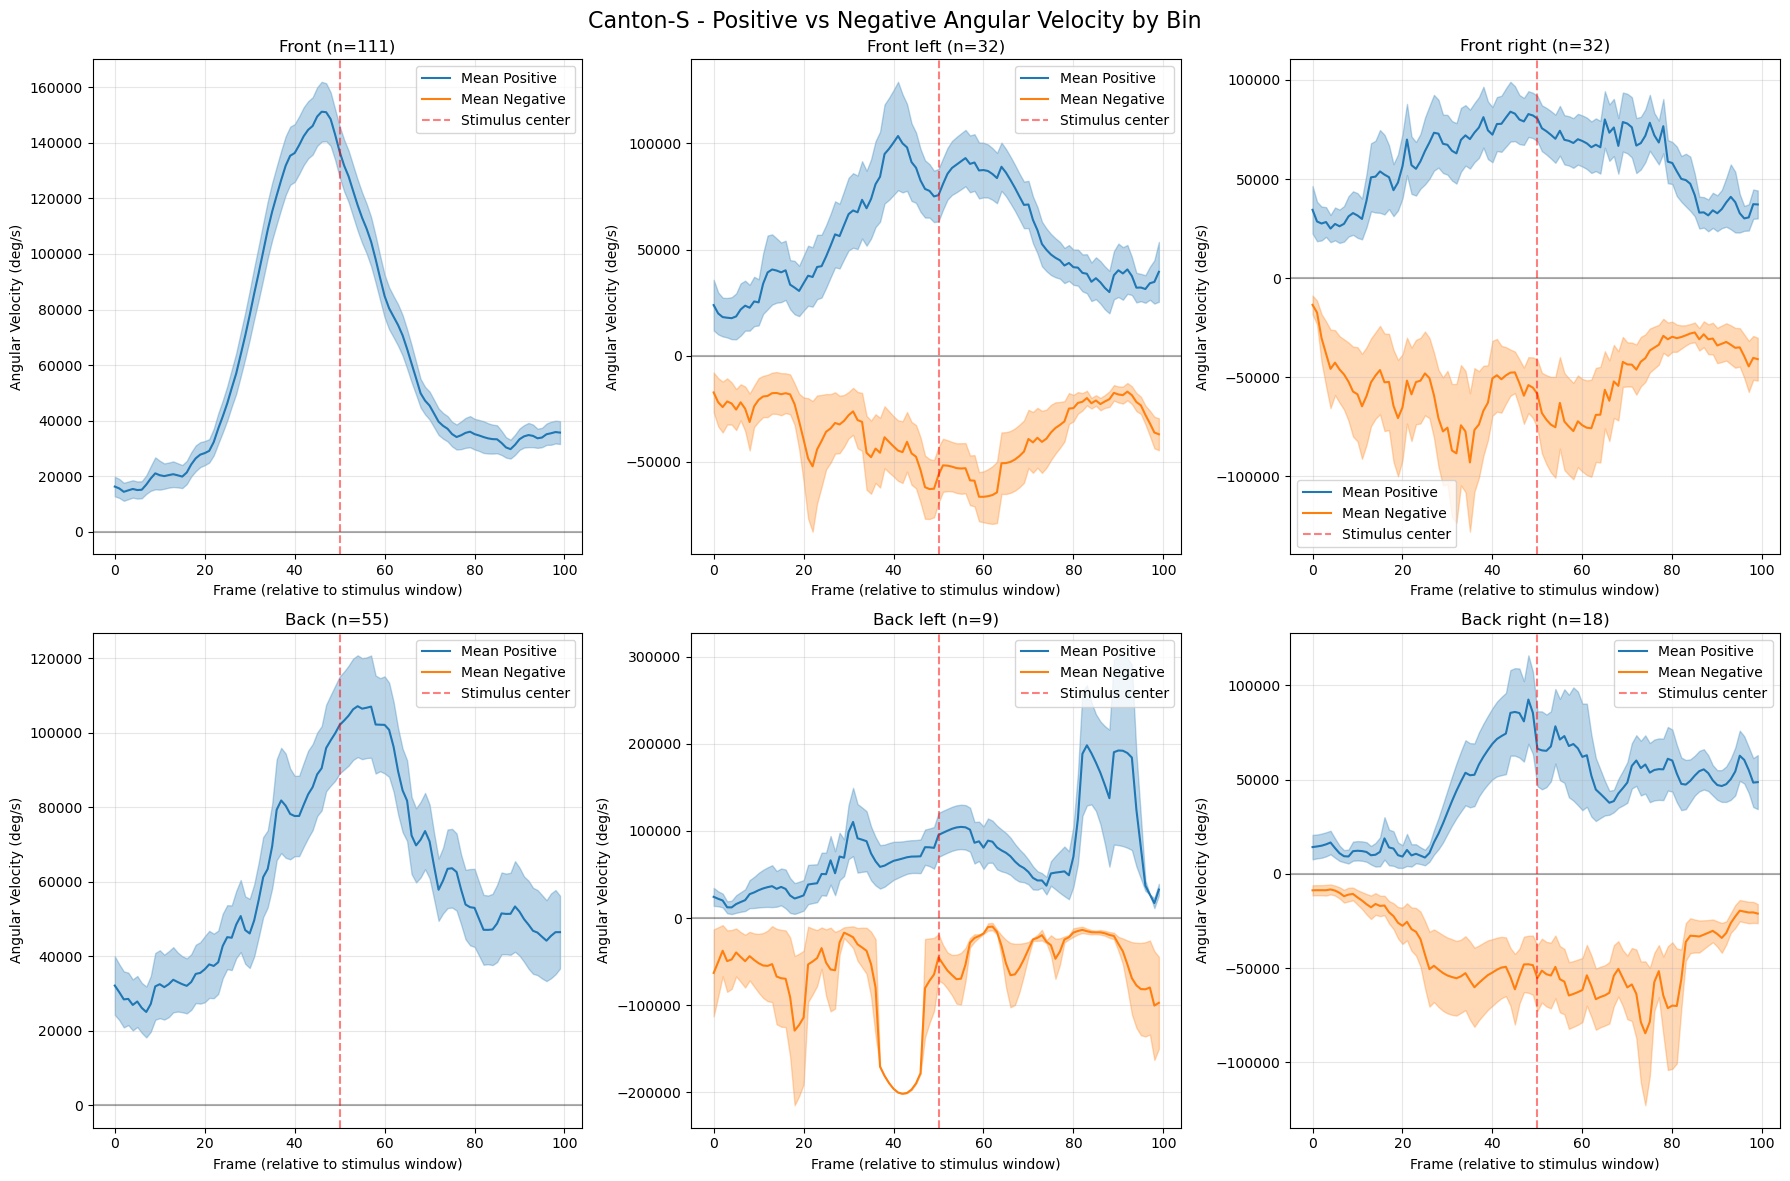

In [18]:
def plot_pos_neg_angular_velocity(organized_data, group_name="Dataset"):
    bins = ['front', 'front left', 'front right', 'back', 'back left', 'back right']
    colors = ['green', 'orange', 'blue', 'red', 'purple', 'brown']
    time_frames = np.arange(organized_data[bins[0]]['angular_velocity'].shape[1])  # assuming all have same length
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    for i, bin_name in enumerate(bins):
        ax = axes[i]
        data = organized_data.get(bin_name, {})
        angular_velocity = data.get('angular_velocity_deg', None)
        if angular_velocity is None or angular_velocity.size == 0:
            ax.set_title(f"{bin_name.capitalize()} (n=0)")
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
            continue

        # Mask for positive and negative angular velocity (per trial, per timepoint)
        pos_mask = angular_velocity > 0
        neg_mask = angular_velocity < 0

        # Set all values not matching the mask to nan (so they don't affect mean)
        pos_vals = np.where(pos_mask, angular_velocity, np.nan)
        neg_vals = np.where(neg_mask, angular_velocity, np.nan)

        # Compute means (ignoring NaNs)
        mean_pos = np.nanmean(pos_vals, axis=0)
        sem_pos = np.nanstd(pos_vals, axis=0) / np.sqrt(np.sum(~np.isnan(pos_vals), axis=0))
        mean_neg = np.nanmean(neg_vals, axis=0)
        sem_neg = np.nanstd(neg_vals, axis=0) / np.sqrt(np.sum(~np.isnan(neg_vals), axis=0))

        ax.plot(time_frames, np.degrees(mean_pos), color='C0', label='Mean Positive')
        ax.fill_between(time_frames, 
                        np.degrees(mean_pos - sem_pos), 
                        np.degrees(mean_pos + sem_pos), 
                        alpha=0.3, color='C0')
        ax.plot(time_frames, np.degrees(mean_neg), color='C1', label='Mean Negative')
        ax.fill_between(time_frames, 
                        np.degrees(mean_neg - sem_neg), 
                        np.degrees(mean_neg + sem_neg), 
                        alpha=0.3, color='C1')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax.axvline(time_frames[len(time_frames)//2], color='red', linestyle='--', alpha=0.5, label='Stimulus center')
        ax.set_title(f'{bin_name.capitalize()} (n={angular_velocity.shape[0]})')
        ax.set_xlabel('Frame (relative to stimulus window)')
        ax.set_ylabel('Angular Velocity (deg/s)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.suptitle(f'{group_name} - Positive vs Negative Angular Velocity by Bin', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_pos_neg_angular_velocity(cs_responsive_data, group_name="Canton-S")